In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
import qiskit
from qiskit import IBMQ, QuantumCircuit, execute, transpile, assemble, Aer, ClassicalRegister, QuantumRegister
from qiskit.result import marginal_counts
from qiskit.visualization import plot_histogram, circuit_drawer
from qiskit.tools.monitor import job_monitor

In [3]:
#The quantum strategy is given by the presentation

In [4]:
# Functions used in the demo

# U1 and U2 are the circuit components that represent observables, i.e. the strategy.
def U1(t):
    qc_U = QuantumCircuit(6)
    if t == 0:
        qc_U.h(range(1,3))
    elif t == 1:
        qc_U
    elif t == 2:
        qc_U.h(range(0,2))
    elif t == 3:
        qc_U.h(0)
        qc_U.h(2)
    elif t == 4:
        qc_U.cx(0,1)
        qc_U.cz(0,2)
        qc_U.cx(1,2)
        qc_U.h(range(0,2))
    return qc_U

def U2(t):
    qc_U = QuantumCircuit(6)
    if t == 0:
        qc_U.h(range(4,6))
    elif t == 1:
        qc_U
    elif t == 2:
        qc_U.h(range(3,5))
    elif t == 3:
        qc_U.h(3)
        qc_U.h(5)
    elif t == 4:
        qc_U.cx(3,4)
        qc_U.cz(3,5)
        qc_U.cx(4,5)
        qc_U.h(range(3,5))
    return qc_U

def state_to_eigv(x):
    if x == '0':
        eigv = 1
    else: eigv = -1
    return eigv

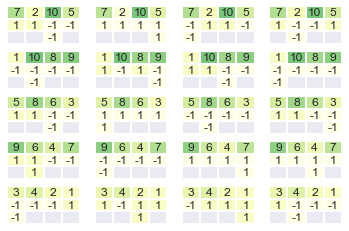

In [5]:
#Run on a simulator

# Simulation for all the 5(hyperedges) x 4(vertices) = 20 cases
fig, axs = plt.subplots(5, 4)
plt.title("", fontsize=12)

jk_index_table = np.array([[10,5,7,2],[10,9,8,1],[6,5,8,3],[6,9,7,4],[3,2,1,4]])
 
for j in range(5):
    for v in range(4):
        
        dict_ptgrm_returns = [{7:22, 2:22, 10:22, 5:22}, {1:22, 10:22, 8:22, 9:22},
                      {5:22, 8:22, 6:22, 3:22}, {9:22, 6:22, 4:22, 7:22},
                      {3:22, 4:22, 2:22, 1:22}]
        
        # Generate two Bell states
        qc = QuantumCircuit(6,6)
        qc.h(range(3))
        qc.cx(0,3)
        qc.cx(1,4)
        qc.cx(2,5)
        
        qc_ob = qc.compose(U1(j)).compose(U2(j))
        
        for l in range(6):
            qc_ob.barrier()
            qc_ob.measure(l,l)
        
        simulator = Aer.get_backend('qasm_simulator') #you can also use other simulators. ex) 'statevector_simulator', 'aer_simulator'
        mapped_qc_ob = transpile(qc_ob, backend=simulator)
        qobj = assemble(mapped_qc_ob, backend=simulator, shots=1)
        job = simulator.run(qobj)
        
        q0_post = marginal_counts(job.result(), indices=[0]).get_counts()
        q1_post = marginal_counts(job.result(), indices=[1]).get_counts()
        q2_post = marginal_counts(job.result(), indices=[2]).get_counts()
        q3_post = marginal_counts(job.result(), indices=[3]).get_counts()
        q4_post = marginal_counts(job.result(), indices=[4]).get_counts()
        q5_post = marginal_counts(job.result(), indices=[5]).get_counts()
                
        a1 = state_to_eigv(list(q0_post)[0])
        a2 = state_to_eigv(list(q1_post)[0])
        a3 = state_to_eigv(list(q2_post)[0])
        
        if j == 4:
            a4 = -1*a1*a2*a3
        else: a4 = 1*a1*a2*a3
        
        b1 = state_to_eigv(list(q3_post)[0])
        b2 = state_to_eigv(list(q4_post)[0])
        b3 = state_to_eigv(list(q5_post)[0])
        
        if j == 4:
            b4 = -1*a1*a2*a3
        else: b4 = 1*a1*a2*a3
        
        a = [a1,a2,a3,a4]
        b = [b1,b2,b3,b4]
        
        Alice_Bob_return = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0]])
        edge = dict_ptgrm_returns[j].copy()
        
        for i in range(4):
            dict_ptgrm_returns[j][jk_index_table[j,i]] = a[i]
        
        edge[jk_index_table[j,v]] = b[v]
        
        v0 = dict_ptgrm_returns[j].keys()
        v1 = dict_ptgrm_returns[j].values()
        v2 = edge.values()
        
        Alice_Bob_return[0] = list(v0)
        Alice_Bob_return[1] = list(v1)    
        Alice_Bob_return[2] = list(v2)
        
        mask = np.zeros((3,4))
        
        for l in range(4):
            if Alice_Bob_return[2][l] == 22:
                mask[2][l] = 1
            
        #Visualize a numpy array in python using seaborn        
        sns.heatmap(Alice_Bob_return, ax=axs[j,v], cmap="YlGn", mask=mask, linewidths=.30, center=10, annot=True, cbar=None, xticklabels=False, yticklabels=False)     

In [6]:
from qiskit import IBMQ
IBMQ.enable_account('8ba2543d39b8295256079c0e8bfcfdb130e2b49a5734ecb4f094d05edb25994cbb8124761d627575f10165b1c12b2c90d25537427879ce1431eb11fad2a46ac0')

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [7]:
#IBMQ.providers()

In [8]:
provider = IBMQ.get_provider(hub='ibm-q-education', group='ibm-quantum-1', project='quantum-hackatho')

In [ ]:
#provider.backends()

In [10]:
backend = provider.get_backend('ibm_lagos')

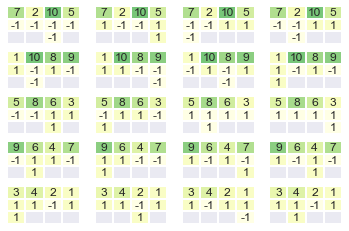

In [12]:
#Run on a real backend ('ibm_')

# Simulation for all the 5(hyperedges) x 4(vertices) = 20 cases
fig, axs = plt.subplots(5, 4)
plt.title("", fontsize=12)

jk_index_table = np.array([[10,5,7,2],[10,9,8,1],[6,5,8,3],[6,9,7,4],[3,2,1,4]])
 
for j in range(5):
    for v in range(4):
        
        dict_ptgrm_returns = [{7:22, 2:22, 10:22, 5:22}, {1:22, 10:22, 8:22, 9:22},
                      {5:22, 8:22, 6:22, 3:22}, {9:22, 6:22, 4:22, 7:22},
                      {3:22, 4:22, 2:22, 1:22}]
        
        # Generate two Bell states
        qc = QuantumCircuit(6,6)
        qc.h(range(3))
        qc.cx(0,3)
        qc.cx(1,4)
        qc.cx(2,5)
        
        qc_ob = qc.compose(U1(j)).compose(U2(j))
        
        for l in range(6):
            qc_ob.barrier()
            qc_ob.measure(l,l)
        
        mapped_qc_ob = transpile(qc_ob, backend=backend)
        qobj = assemble(mapped_qc_ob, backend=backend, shots=1)
        job = backend.run(qobj)
        
        q0_post = marginal_counts(job.result(), indices=[0]).get_counts()
        q1_post = marginal_counts(job.result(), indices=[1]).get_counts()
        q2_post = marginal_counts(job.result(), indices=[2]).get_counts()
        q3_post = marginal_counts(job.result(), indices=[3]).get_counts()
        q4_post = marginal_counts(job.result(), indices=[4]).get_counts()
        q5_post = marginal_counts(job.result(), indices=[5]).get_counts()
                
        a1 = state_to_eigv(list(q0_post)[0])
        a2 = state_to_eigv(list(q1_post)[0])
        a3 = state_to_eigv(list(q2_post)[0])
        
        if j == 4:
            a4 = -1*a1*a2*a3
        else: a4 = 1*a1*a2*a3
        
        b1 = state_to_eigv(list(q3_post)[0])
        b2 = state_to_eigv(list(q4_post)[0])
        b3 = state_to_eigv(list(q5_post)[0])
        
        if j == 4:
            b4 = -1*a1*a2*a3
        else: b4 = 1*a1*a2*a3
        
        a = [a1,a2,a3,a4]
        b = [b1,b2,b3,b4]
        
        Alice_Bob_return = np.array([[0,0,0,0],[0,0,0,0],[0,0,0,0]])
        edge = dict_ptgrm_returns[j].copy()
        
        for i in range(4):
            dict_ptgrm_returns[j][jk_index_table[j,i]] = a[i]
        
        edge[jk_index_table[j,v]] = b[v]
        
        v0 = dict_ptgrm_returns[j].keys()
        v1 = dict_ptgrm_returns[j].values()
        v2 = edge.values()
        
        Alice_Bob_return[0] = list(v0)
        Alice_Bob_return[1] = list(v1)    
        Alice_Bob_return[2] = list(v2)
        
        mask = np.zeros((3,4))
        
        for l in range(4):
            if Alice_Bob_return[2][l] == 22:
                mask[2][l] = 1
            
        #Visualize a numpy array in python using seaborn        
        sns.heatmap(Alice_Bob_return, ax=axs[j,v], cmap="YlGn", mask=mask, linewidths=.30, center=10, annot=True, cbar=None, xticklabels=False, yticklabels=False)     